## Part 4 - Neural Networks and Convolutional Neural Networks

Importing the required libraries and checking for the python version.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [3]:
x_train, y_train,x_test, y_test = load_data()

In [4]:
x_train.shape

(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

In [6]:
x_train = np.asarray(x_train)
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

### 1) Linear Perceptron

In [7]:
from sklearn.linear_model import Perceptron

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(x_train, y_train)

predictions = per_clf.predict(x_test)

In [8]:
from sklearn.metrics import accuracy_score

accuracy_p = accuracy_score(y_test, predictions)
print('Accuracy for Linear Perceptron = ', accuracy_p)

Accuracy for Linear Perceptron =  0.8841423948220065


### Comparing Linear Perceptron with other linear models

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import SGDClassifier, Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

##### Reference :

In [11]:
classifiers = [
    ("SGD", SGDClassifier()),
    ("Perceptron", Perceptron()),
    ("Logistic Regression" ,LogisticRegression(solver='saga', max_iter=1000, random_state=42)),
    ("Passive-Aggressive I", PassiveAggressiveClassifier(max_iter=1000, random_state=42,loss='hinge', C=1.0)),
    ("Passive-Aggressive II", PassiveAggressiveClassifier(max_iter=1000, random_state=42,loss='squared_hinge', C=1.0)),

]

In [13]:
accuracies =[]
for clf_name, clf in classifiers: 
    
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(clf_name)
        accuracies.append((clf_name, accuracy))
    

SGD
Perceptron


c:\Users\Poornima\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression
Passive-Aggressive I
Passive-Aggressive II


In [28]:
print(accuracies)


[('SGD', 0.8475728155339806), ('Perceptron', 0.8792880258899677), ('Logistic Regression', 0.888673139158576), ('Passive-Aggressive I', 0.6870550161812298), ('Passive-Aggressive II', 0.6870550161812298)]


ValueError: too many values to unpack (expected 2)

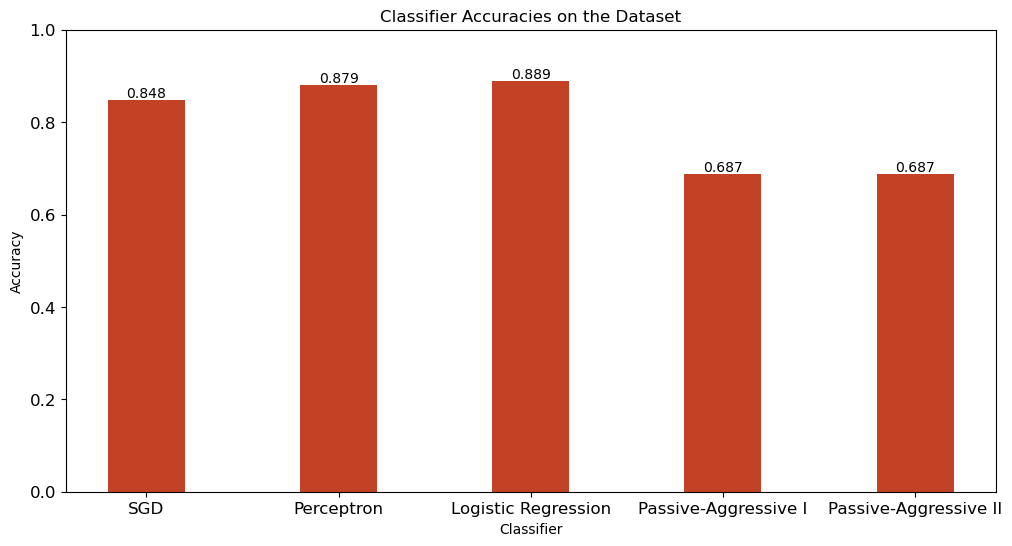

In [26]:

plt.figure(figsize=(12, 6))

clf_name, clf_accuracies = zip(*accuracies)


#classifiers_names, mean_accs = zip(*mean_accuracies)
bars=plt.bar(clf_name, clf_accuracies, color="#C34226",width=0.4)
plt.title('Classifier Accuracies on the Dataset')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
for bar, accuracy in zip(bars, clf_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{accuracy:.3f}', ha='center', va='bottom')


plt.show()



### 2) Multilayer Perceptron

In [31]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=1000, random_state=42)
mlp.fit(x_train, y_train)

mlp_pred = mlp.predict(x_test)

In [32]:
from sklearn.metrics import accuracy_score

accuracy_MLP = accuracy_score(y_test, mlp_pred)
print('Accuracy for Multilayer Perceptron = ', accuracy_MLP)

Accuracy for Multilayer Perceptron =  0.8009708737864077


### 2.1) Experimenting with various Neural Network parameters

In [29]:
# Solver : sgd
# Activation Functions: Logistic, ReLU, tanh
# Number & Size of Layers: (100, 50), (150, 100, 50), (50, 50, 50), (50, 40, 30, 20, 10)
# Learning Rate: constant, invscaling, adaptive
# Epochs: 200, 600, 1000
# Momentum: 0.9, 0.45
pd.set_option('display.max_colwidth', None)

def experiment_parameters_mlp(x_train, y_train, x_test, y_test):
    activ_funcs = ['logistic', 'relu', 'tanh']
    number_layers = [(100,50), (150,100,5), (50,50,50), (50,40,30,20,10)] # (150,100,5), (50,50,50), (50,40,30,20,10)
    learning_rate = ['constant', 'invscaling', 'adaptive'] # 'invscaling', 'adaptive'
    epochs = [200, 600, 1000] # 600, 1000
    momentum_val = [0.49, 0.9] # 0.9

    models = []

    for i in activ_funcs:
        for j in number_layers:
            for k in learning_rate:
                for l in epochs:
                    for m in momentum_val:
                        model = MLPClassifier (
                            #solver='sgd',  
                            activation=i,  
                            hidden_layer_sizes=j,           
                            learning_rate=k,      
                            max_iter=l,    
                            momentum=m,               
                            random_state=42
                        )
                        model.fit(x_train, y_train)
                        models.append(model)

    model_names = []
    accuracies = []
    for n in range(len(models)):
        model_pred = models[n].predict(x_test)
        model_accuracy = accuracy_score(y_test, model_pred)
        accuracies.append(model_accuracy)
        model_names.append(f'Model {n+1}')

    models_names_df = pd.DataFrame({'Model Name': model_names})
    models_df = pd.DataFrame({'Model': models})
    accuracy_df = pd.DataFrame({'Accuracy': accuracies})

    result_df = pd.concat([models_names_df, models_df, accuracy_df], axis=1)
    
    return result_df

In [33]:
result = experiment_parameters_mlp(x_train, y_train, x_test, y_test)


In [34]:
result

,Model Name,Model,Accuracy
0,Model 1,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n momentum=0.49, random_state=42)",0.242718
1,Model 2,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n random_state=42)",0.242718
2,Model 3,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n momentum=0.49, random_state=42)",0.242718
3,Model 4,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n random_state=42)",0.242718
4,Model 5,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, momentum=0.49, random_state=42)",0.242718
...,...,...,...
211,Model 212,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', random_state=42)",0.242718
212,Model 213,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', max_iter=600, momentum=0.49,\n random_state=42)",0.242718
213,Model 214,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', max_iter=600, random_state=42)",0.242718
214,Model 215,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', max_iter=1000, momentum=0.49,\n random_state=42)",0.242718


In [35]:
pd.set_option('display.max_rows', None)
result

,Model Name,Model,Accuracy
0,Model 1,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n momentum=0.49, random_state=42)",0.242718
1,Model 2,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n random_state=42)",0.242718
2,Model 3,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n momentum=0.49, random_state=42)",0.242718
3,Model 4,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n random_state=42)",0.242718
4,Model 5,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, momentum=0.49, random_state=42)",0.242718
5,Model 6,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, random_state=42)",0.242718
6,Model 7,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', momentum=0.49, random_state=42)",0.242718
7,Model 8,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', random_state=42)",0.242718
8,Model 9,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, momentum=0.49,\n random_state=42)",0.242718
9,Model 10,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, random_state=42)",0.242718


In [ ]:
def calculate_train_test_acc(x_train, y_train):
    accuracies = []
    for n in range(len(result)):
        model_pred = result["Model"][n].predict(x_train)
        model_accuracy = accuracy_score(y_train, model_pred)
        accuracies.append(model_accuracy)

    accuracy_df = pd.DataFrame({'Training Accuracy': accuracies})
    test_acc_df = pd.DataFrame({'Testing Accuracy' : result["Accuracy"]})

    result_df = pd.concat([result["Model Name"], result["Model"], accuracy_df, test_acc_df], axis=1)
    
    return result_df

In [ ]:
final_df = calculate_train_test_acc(x_train, y_train)
final_df

,Model Name,Model,Training Accuracy,Testing Accuracy
0,Model 1,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n momentum=0.49, random_state=42)",0.232198,0.242718
1,Model 2,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n random_state=42)",0.232198,0.242718
2,Model 3,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n momentum=0.49, random_state=42)",0.232198,0.242718
3,Model 4,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n random_state=42)",0.232198,0.242718
4,Model 5,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, momentum=0.49, random_state=42)",0.232198,0.242718
5,Model 6,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, random_state=42)",0.232198,0.242718
6,Model 7,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', momentum=0.49, random_state=42)",0.232198,0.242718
7,Model 8,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', random_state=42)",0.232198,0.242718
8,Model 9,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, momentum=0.49,\n random_state=42)",0.232198,0.242718
9,Model 10,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, random_state=42)",0.232198,0.242718


In [ ]:
#
max_acc = result["Accuracy"].max()
print("Maximum Accuracy = ", max_acc)

max_acc_df = result[result["Accuracy"] == max_acc].copy()

print(f"Total Number of Models with {max_acc} accuracy = ", len(max_acc_df))
max_acc_df

Maximum Accuracy =  0.8773462783171521
Total Number of Models with 0.8773462783171521 accuracy =  18


,Model Name,Model,Accuracy
108,Model 109,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), momentum=0.49, random_state=42)",0.877346
109,Model 110,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), random_state=42)",0.877346
110,Model 111,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, momentum=0.49,\n random_state=42)",0.877346
111,Model 112,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, random_state=42)",0.877346
112,Model 113,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, momentum=0.49,\n random_state=42)",0.877346
113,Model 114,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, random_state=42)",0.877346
114,Model 115,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n momentum=0.49, random_state=42)",0.877346
115,Model 116,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n random_state=42)",0.877346
116,Model 117,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, momentum=0.49, random_state=42)",0.877346
117,Model 118,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, random_state=42)",0.877346


In [ ]:
from sklearn.model_selection import cross_val_score

y_test = y_test.ravel()
cross_val = []

for i in range(len(max_acc_df)):
    model = max_acc_df.iloc[i]["Model"]
    scores = cross_val_score(model, x_test, y_test, scoring="accuracy", cv=10)
    cross_val.append(scores.mean())

cross_val_df = pd.DataFrame({"Cross Validation Score" : cross_val})
max_acc_df = max_acc_df.reset_index(drop=True)

cv_df = pd.concat([max_acc_df, cross_val_df], axis=1)
cv_df
    

,Model Name,Model,Accuracy,Cross Validation Score
0,Model 109,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), momentum=0.49, random_state=42)",0.877346,0.847249
1,Model 110,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), random_state=42)",0.877346,0.847249
2,Model 111,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, momentum=0.49,\n random_state=42)",0.877346,0.847249
3,Model 112,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, random_state=42)",0.877346,0.847249
4,Model 113,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, momentum=0.49,\n random_state=42)",0.877346,0.847249
5,Model 114,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, random_state=42)",0.877346,0.847249
6,Model 115,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n momentum=0.49, random_state=42)",0.877346,0.847249
7,Model 116,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n random_state=42)",0.877346,0.847249
8,Model 117,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, momentum=0.49, random_state=42)",0.877346,0.847249
9,Model 118,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, random_state=42)",0.877346,0.847249


In [ ]:
from sklearn.model_selection import GridSearchCV

mlp_grid = MLPClassifier()

param_grid = {
    'activation' : ['logistic', 'relu', 'tanh'],
    'hidden_layer_sizes' : [(100,50), (150,100,5), (50,50,50), (50,40,30,20,10)], 
    'learning_rate' : ['constant', 'invscaling', 'adaptive'], 
    'max_iter' : [200, 600, 1000], 
    'momentum' : [0.49, 0.9]
}

gs = GridSearchCV(mlp_grid, param_grid, scoring='accuracy', cv=10, n_jobs=-1)

gs.fit(x_train, y_train)

best_params = gs.best_params_
print("Best parameters: ", best_params)
best_model = gs.best_estimator_
print("Best model: ", best_model)

gs_pred = best_model.predict(x_test)
accuracy_gs = accuracy_score(y_test, gs_pred)
print(f"Accuracy on Test Set: {accuracy_gs:.4f}")

Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'invscaling', 'max_iter': 1000, 'momentum': 0.49}
Best model:  MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',
              max_iter=1000, momentum=0.49)
Accuracy on Test Set: 0.8773


## Exploring the Best Model (GridSearch)

In [46]:
from sklearn.neural_network import MLPClassifier

mlp_best_model = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=1000, learning_rate='invscaling',momentum=0.49)
mlp_best_model.fit(x_train, y_train)

mlp_pred_test= mlp_best_model.predict(x_test)

In [47]:
from sklearn.metrics import accuracy_score

accuracy_best_mlp_model_test = accuracy_score(y_test, mlp_pred_test)
print('Test accuracy for best mlp found = ', accuracy_best_mlp_model_test)

Test accuracy for best mlp found =  0.8197411003236246


In [49]:
from sklearn.metrics import accuracy_score

mlp_pred_train = mlp_best_model.predict(x_train)
accuracy_best_mlp_model_train = accuracy_score(y_train, mlp_pred_train)
print('Training accuracy for the best MLP model found = ', accuracy_best_mlp_model_train)


Training accuracy for the best MLP model found =  0.8867905056759546


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

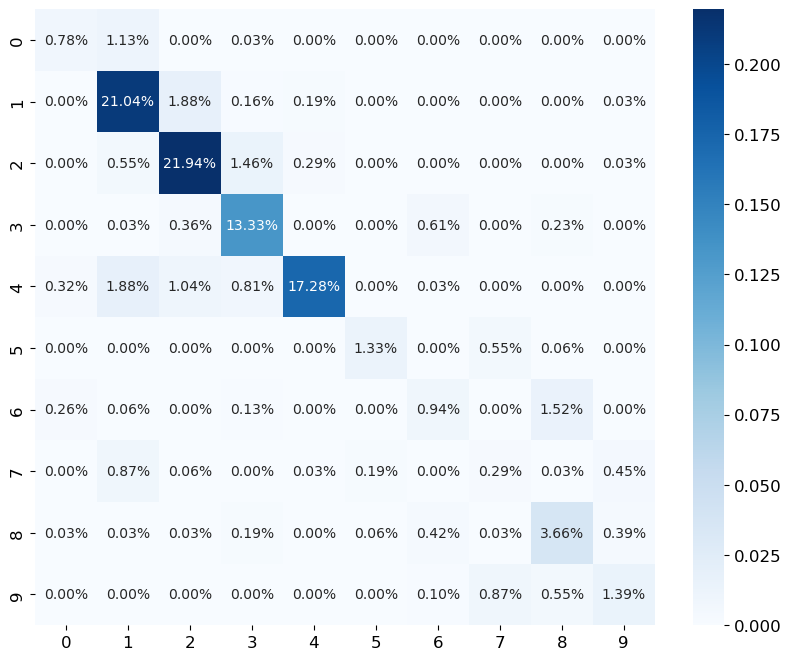

In [53]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_test,mlp_pred_test )
import seaborn as sns
plt.figure(figsize=(10, 8)) 
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')
plt.tight_layout

In [93]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_prediction(image_index, x_train, y_train, mlp_model):
    plt.figure(figsize=(10, 6))

    img = x_train[image_index]
    true_label = y_train[image_index]

    img = img.reshape((48, 48))
    predicted_probabilities = mlp_model.predict_proba(img.reshape(1, -1))[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

    # Shoow image 
    ax1.imshow(img)  
    ax1.set_title(f'True Label: {true_label}')

    # Graph prediction
    classes = np.arange(len(predicted_probabilities))
    ax2.bar(classes, predicted_probabilities, color='#4a7ba6')
    ax2.set_title('Prediction')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Probability')
    ax2.set_xticks(classes)
    ax2.set_xticklabels([f'Class {i}' for i in classes])
    plt.tight_layout
    plt.show()



<Figure size 1000x600 with 0 Axes>

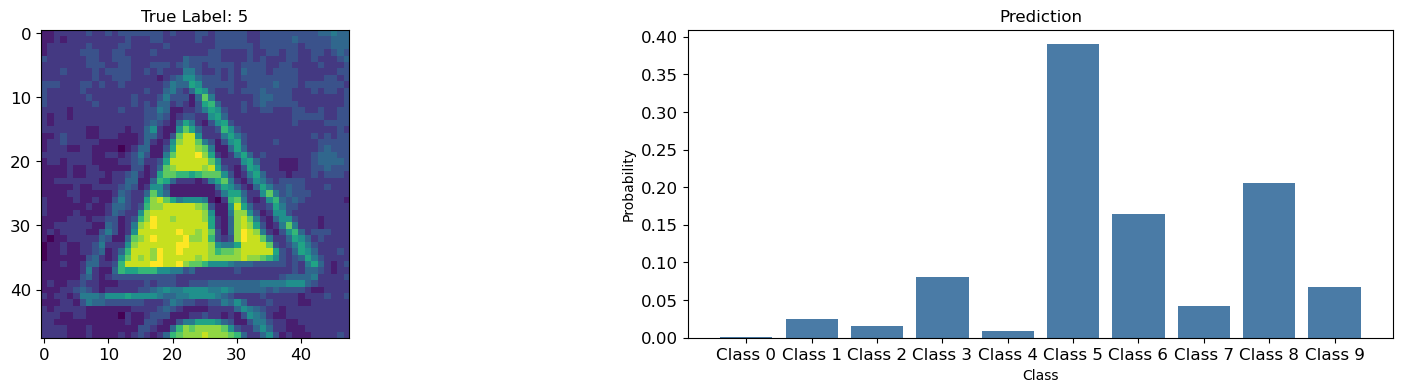

In [94]:
visualize_prediction(8208, x_train, y_train, mlp_best_model)
#visualize_prediction(5000, x_train, y_train, mlp_best_model)



### Different activation functions

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# Assuming you have your data (X, y) ready

activations = ['logistic', 'relu', 'tanh']
test_accuracies = []
train_accuracies = []
cross_val_accuracies = []

for activation in activations:
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation=activation, max_iter=1000, learning_rate='invscaling', momentum=0.49)
    
   
    
    # Train the model
    mlp_model.fit(x_train, y_train)
    
    # Calculate accuracies
    test_accuracy = mlp_model.score(x_test, y_test)
    train_accuracy = mlp_model.score(x_train, y_train)
    cross_val_accuracy = np.mean(cross_val_score(mlp_model, x_train, y_train,scoring="accuracy", cv=10))  
    
    # Store accuracies in lists
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)
    cross_val_accuracies.append(cross_val_accuracy)




In [108]:
print("train accuracy list :", train_accuracies)
print("test accuracy list :",test_accuracies)
print("cross-val accuracy list :",cross_val_accuracies )

train accuracy list : [0.22910216718266255, 0.9550051599587204, 0.23219814241486067]
test accuracy list : [0.23300970873786409, 0.8922330097087379, 0.24271844660194175]
cross-val accuracy list : [0.24520123839009286, 0.835810113519092, 0.22291021671826625]


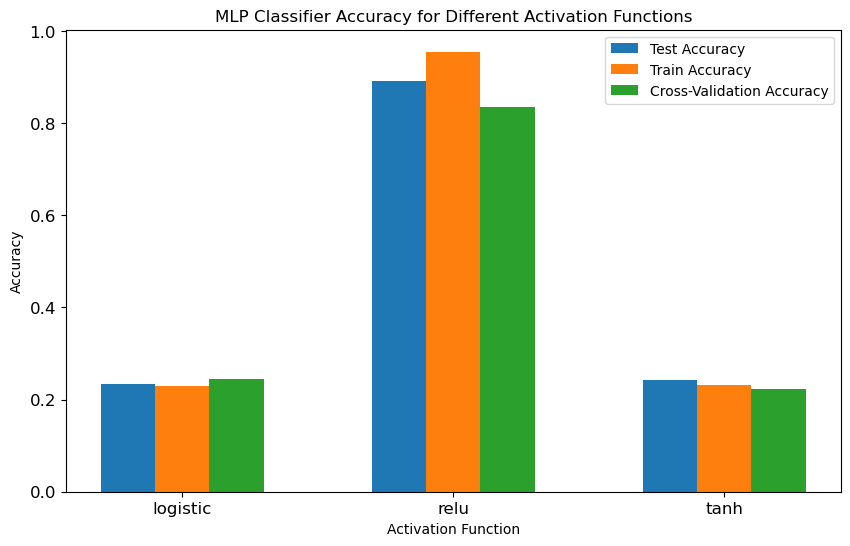

In [109]:
# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(activations))

rects1 = ax.bar(index, test_accuracies, bar_width, label='Test Accuracy')
rects2 = ax.bar(index + bar_width, train_accuracies, bar_width, label='Train Accuracy')
rects3 = ax.bar(index + 2*bar_width, cross_val_accuracies, bar_width, label='Cross-Validation Accuracy')

ax.set_xlabel('Activation Function')
ax.set_ylabel('Accuracy')
ax.set_title('MLP Classifier Accuracy for Different Activation Functions')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(activations)
ax.legend()

plt.show()

### Different Momentum

In [110]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
import numpy as np

momentum_values = np.linspace(0,1,10)
momentum_test_accuracies = []



for momentum in momentum_values:
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', max_iter=1000, learning_rate='invscaling', momentum=momentum)
    
    # Train the model
    mlp_model.fit(x_train, y_train)
    
    # Calculate test accuracy
    test_accuracy = mlp_model.score(x_test, y_test)
    
    # Store test accuracy in the list
    momentum_test_accuracies.append(test_accuracy)



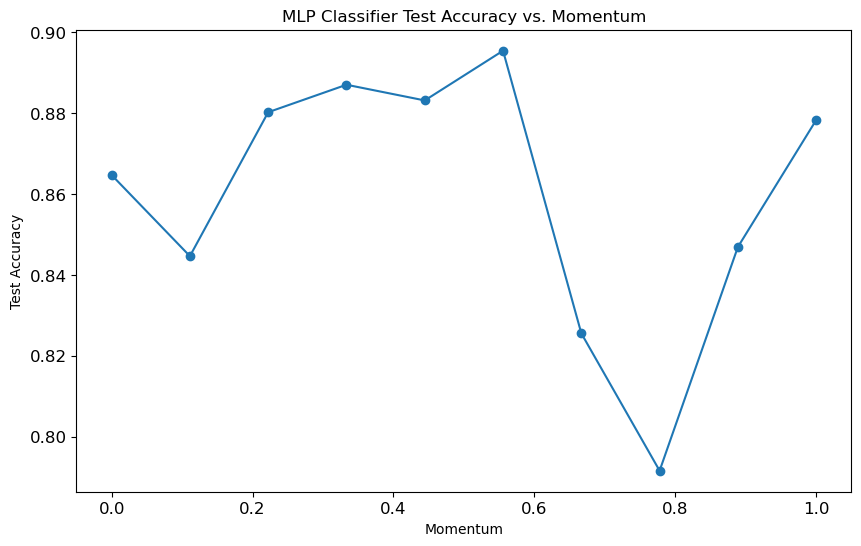

In [111]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(momentum_values, momentum_test_accuracies, marker='o')
plt.title('MLP Classifier Test Accuracy vs. Momentum')
plt.xlabel('Momentum')
plt.ylabel('Test Accuracy')
plt.show()


### Different learning rates

In [114]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split

learningRate = ['invscaling', 'adaptive', 'constant']
learningRate_test_accuracies = []
learningRate_train_accuracies = []
learningRate_cross_val_accuracies = []

for learning_rate in learningRate:
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', max_iter=1000, learning_rate=learning_rate, momentum=0.49)
    
   
    
    # Train the model
    mlp_model.fit(x_train, y_train)
    
    # Calculate accuracies
    learningRate_test_accuracy = mlp_model.score(x_test, y_test)
    learningRate_train_accuracy = mlp_model.score(x_train, y_train)
    learningRate_cross_val_accuracy = np.mean(cross_val_score(mlp_model, x_train, y_train,scoring="accuracy", cv=10))  
    
    learningRate_train_accuracies.append(learningRate_train_accuracy)
    learningRate_cross_val_accuracies.append(learningRate_cross_val_accuracy)
    learningRate_test_accuracies.append(learningRate_test_accuracy) 




In [120]:
print("train accuracy list :", learningRate_train_accuracies)
print("test accuracy list :",learningRate_test_accuracies)
print("cross-val accuracy list :",learningRate_cross_val_accuracies )

train accuracy list : [0.9270381836945304, 0.4386996904024768, 0.9675954592363261]
test accuracy list : [0.8543689320388349, 0.41423948220064727, 0.8932038834951457]
cross-val accuracy list : [0.7643962848297213, 0.7879256965944272, 0.7454076367389061]


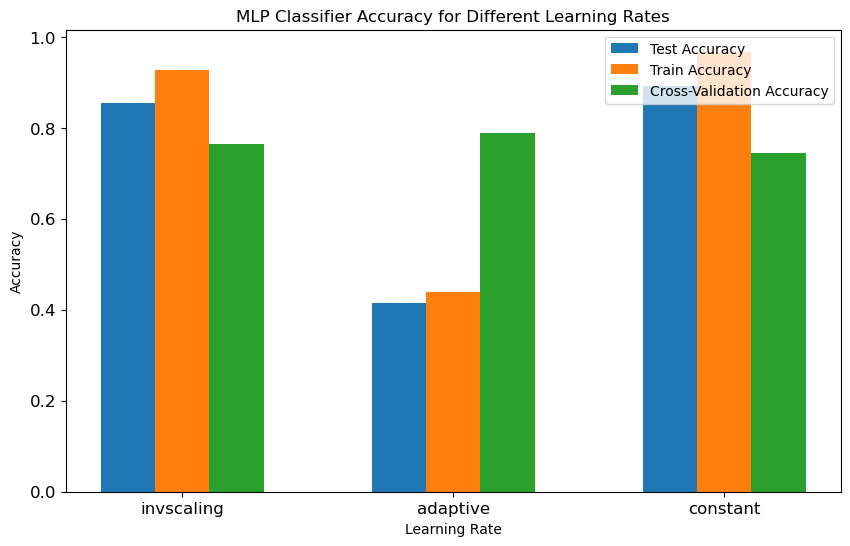

In [118]:
# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(learningRate))

rects1 = ax.bar(index, learningRate_test_accuracies, bar_width, label='Test Accuracy')
rects2 = ax.bar(index + bar_width, learningRate_train_accuracies, bar_width, label='Train Accuracy')
rects3 = ax.bar(index + 2*bar_width, learningRate_cross_val_accuracies, bar_width, label='Cross-Validation Accuracy')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('MLP Classifier Accuracy for Different Learning Rates')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(learningRate)
ax.legend(loc="upper right")

plt.show()